<a href="https://colab.research.google.com/github/sakuna47/Chest-X-ray-Images-Pneumonia-/blob/Backend/XRayBackend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow flask pillow imbalanced-learn matplotlib seaborn

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from flask import Flask, request, render_template
from PIL import Image
import joblib

In [3]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Normal: 1341, Pneumonia: 3875


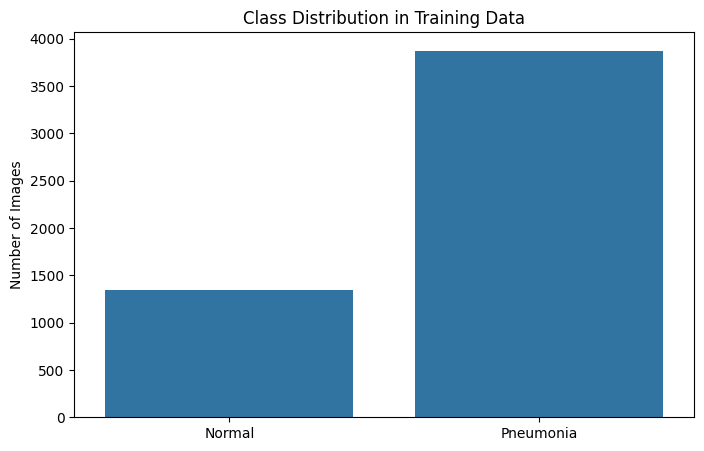

In [4]:


# Define  paths
base_dir = "/content/drive/My Drive/Medical Diagnosis with X-ray Images/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Count images in each class
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

print(f"Normal: {normal_count}, Pneumonia: {pneumonia_count}")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=["Normal", "Pneumonia"], y=[normal_count, pneumonia_count])
plt.title("Class Distribution in Training Data")
plt.ylabel("Number of Images")
plt.show()


In [5]:
# Create a DataFrame for image paths and labels
image_paths = []
labels = []

for label in ["NORMAL", "PNEUMONIA"]:
    class_dir = os.path.join(train_dir, label)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(label)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Encode labels
df["label"] = df["label"].map({"NORMAL": 0, "PNEUMONIA": 1})

# Count current class distribution
pneumonia_count = df["label"].value_counts()[1]  # 4000 pneumonia samples
normal_count = df["label"].value_counts()[0]  # 2000 normal samples

# Only oversample NORMAL class by 500
desired_normal_count = normal_count + 2400  # 2500 total normal samples

ros = RandomOverSampler(sampling_strategy={0: desired_normal_count}, random_state=42)
df_resampled, df_resampled_labels = ros.fit_resample(df[["image_path"]], df["label"])

# Convert resampled data back to a DataFrame
df_resampled["label"] = df_resampled_labels

# Final balanced dataset
df_balanced = pd.concat([df[df["label"] == 1], df_resampled[df_resampled["label"] == 0]])  # Keep original pneumonia data

# Verify final class distribution
print("Final class distribution:")
print(df_balanced["label"].value_counts())

Final class distribution:
label
1    3875
0    3741
Name: count, dtype: int64


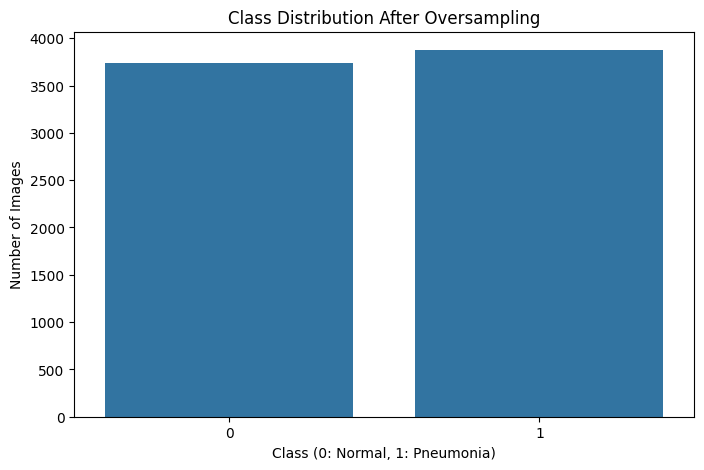

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_balanced is your DataFrame after oversampling
class_counts = df_balanced['label'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class (0: Normal, 1: Pneumonia)')
plt.ylabel('Number of Images')
plt.show()

In [7]:
# Define image dimensions
img_width, img_height = 150, 150

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# Define CNN model
input_layer = Input(shape=(img_width, img_height, 3))
x = Conv2D(32, (3, 3), activation="relu")(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1278s 8s/step - accuracy: 0.7459 - loss: 0.6359 - val_accuracy: 0.6250 - val_loss: 1.0224
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 561ms/step - accuracy: 0.8428 - loss: 0.3479 - val_accuracy: 0.8125 - val_loss: 0.5489
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 540ms/step - accuracy: 0.8530 - loss: 0.3250 - val_accuracy: 0.8125 - val_loss: 0.4800
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 523ms/step - accuracy: 0.8793 - loss: 0.2826 - val_accuracy: 0.8750 - val_loss: 0.3728
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 504ms/step - accuracy: 0.8724 - loss: 0.2743 - val_accuracy: 0.8125 - val_loss: 0.5848
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 504ms/step - accuracy: 0.9061 - loss: 0.2231 - val_accuracy: 0.6250 - val_loss: 0.7077
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 512ms/step - accuracy: 0.8932 - loss: 0.2455 - val_accuracy: 0.7500 - val_loss: 0.6976
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 508ms/step - accuracy: 0.8964 - loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.8427 - loss: 0.3379
Test Accuracy: 0.85


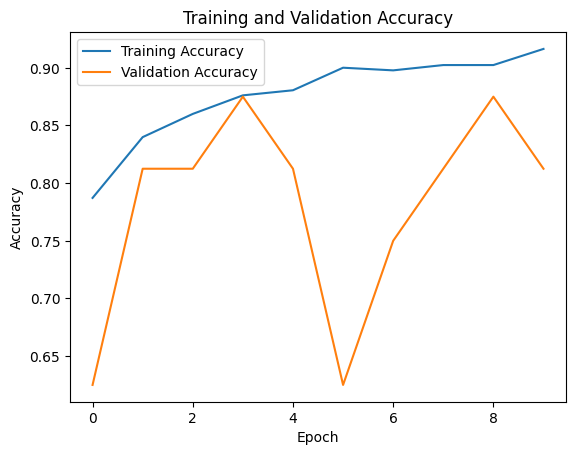

In [9]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [10]:
# Save the model
model.save("pneumonia_model.h5")

# Save the image dimensions and class indices
joblib.dump({"img_width": img_width, "img_height": img_height, "class_indices": train_generator.class_indices}, "model_config.pkl")

['model_config.pkl']